In [1]:
from obspy.core import Stream, read
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path

In [4]:
path_to_files = '/Users/sydneydybing/StrainProject/2024/'

# Events
earthquakes = pd.read_csv(path_to_files + 'M6_catalog_2004-2024.csv', dtype = str)

In [5]:
# earthquakes

In [6]:
weird_events_only = False
if weird_events_only:
    earthquakes = earthquakes.iloc[[4,15]]

small_test = False
if small_test:
    earthquakes = earthquakes.iloc[[11,12,13]]
    
one_at_a_time = False
if one_at_a_time:
#     earthquakes = earthquakes[:1]
    earthquakes = earthquakes.iloc[[29]]

origin_times = earthquakes.time.values
mags = earthquakes.mag.values

# Stations

bsm_mda = pd.read_csv(path_to_files + 'bsm_metadata.csv')
NA_only = bsm_mda.loc[bsm_mda['LONG'] < -110]
stas = NA_only['BNUM'].values

eqs_test = earthquakes[4:5]
ots_test = origin_times[4:5]
mags_test = mags[4:5]
rows_for_extra_times = [8,9,14,16]

dist_array = np.load(path_to_files + 'NA_evt-sta_dist_array_less500km_withdata_withrmssnrs_FILTERED.npy')

# Array order:

# 0. Earthquake identifier
# 1. Earthquake origin time
# 2. Earthquake latitude
# 3. Earthquake longitude
# 4. Earthquake magnitude
# 5. Station name
# 6. Station latitude
# 7. Station longitude
# 8. Hypocentral distance (km)
# 9. RMS strain SNR

In [8]:
dist_array

array([['2023-04-13_M6', '2023-04-13T15:54:53.808Z', '49.215', ...,
        '-123.13141', '495.399747368', '1.2227311375'],
       ['2023-04-13_M6', '2023-04-13T15:54:53.808Z', '49.215', ...,
        '-124.14086', '423.396437732', '1.02566692019'],
       ['2023-04-13_M6', '2023-04-13T15:54:53.808Z', '49.215', ...,
        '-124.42701', '398.201697957', '1.43255101957'],
       ..., 
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785', ...,
        '-123.38342', '346.255216587', '1.00929376661'],
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785', ...,
        '-122.4847', '468.957430617', '1.55806652862'],
       ['2008-01-10_M6.3', '2008-01-10T01:37:19.000Z', '43.785', ...,
        '-122.4205', '451.644312384', '0.950596076971']],
      dtype='<U32')

In [65]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path_to_files + 'filtered_mcmc_arrays/mcmc_results_summary.csv')
mcmc_results_array = mcmc_results.values
mcmc_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time
0,2023-04-13_M6,6.0,B012,299,60,0.237385,0.014034,13.037766,0.106723,13.1
1,2023-04-13_M6,6.0,B927,349,60,0.520998,0.006502,13.746085,0.151608,13.8
2,2023-04-13_M6,6.0,B928,330,60,0.473223,0.010361,12.366934,0.085590,12.4
3,2022-12-20_M6.4,6.4,B030,406,40,0.169725,0.031976,13.733588,0.111113,13.8
4,2022-12-20_M6.4,6.4,B032,359,40,0.143660,0.033170,14.465866,0.101163,14.5
...,...,...,...,...,...,...,...,...,...,...
195,2010-01-10_M6.5,6.5,B035,232,35,0.519965,0.025339,13.499214,0.170624,13.5
196,2010-01-10_M6.5,6.5,B036,233,35,0.515825,0.026782,13.503401,0.170778,13.6
197,2010-01-10_M6.5,6.5,B057,344,35,0.123378,0.020024,15.241258,0.067794,15.3
198,2010-01-10_M6.5,6.5,B933,89,35,0.740438,0.048036,13.192635,0.155758,13.2


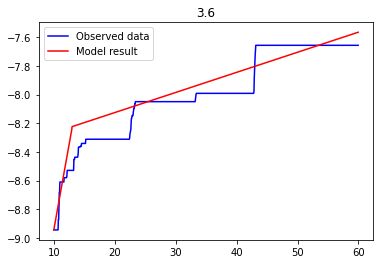

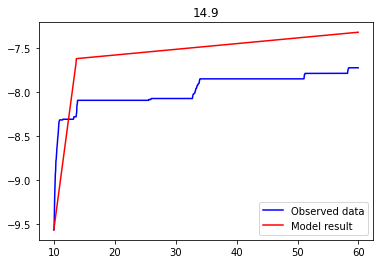

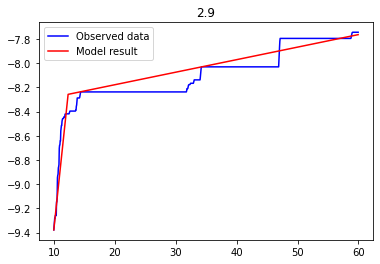

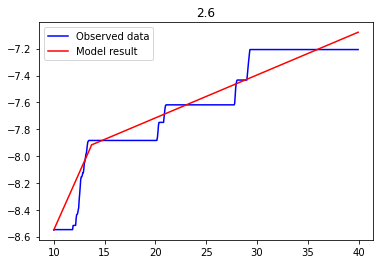

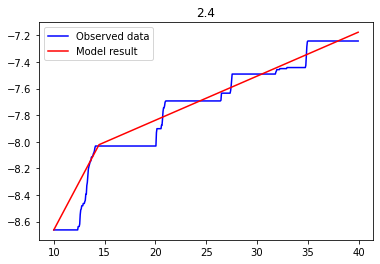

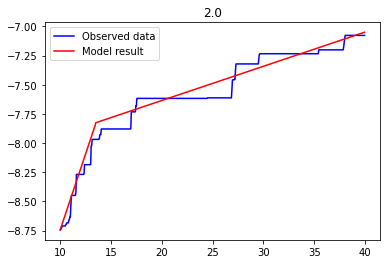

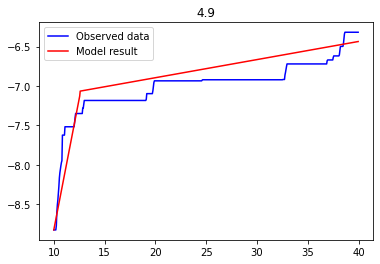

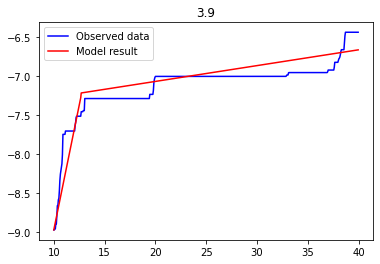

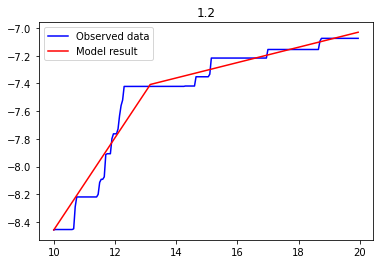

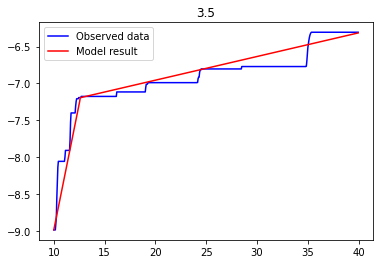

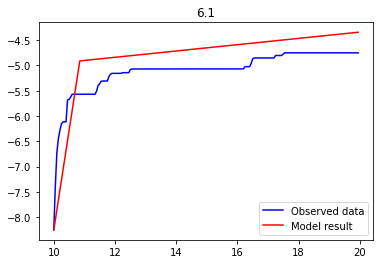

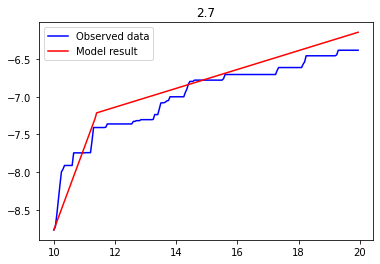

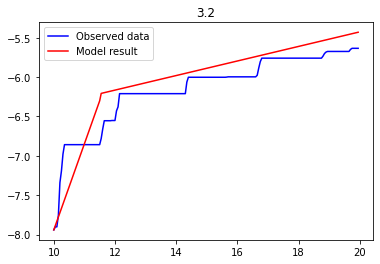

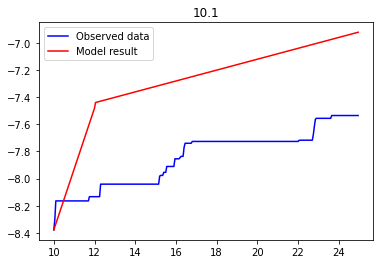

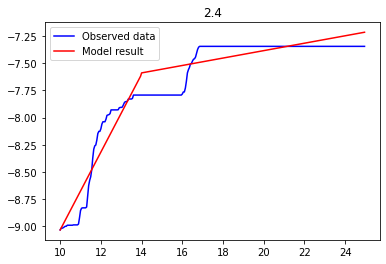

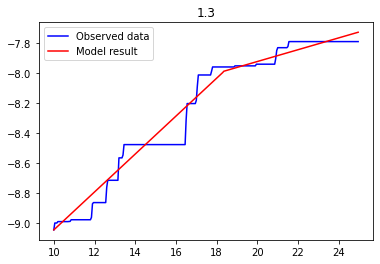

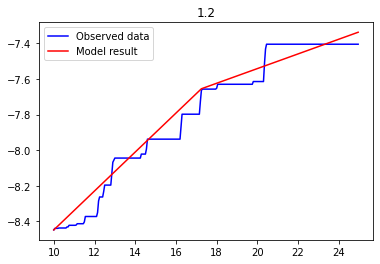

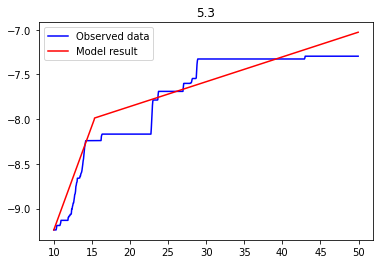

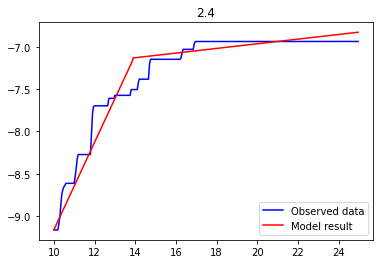

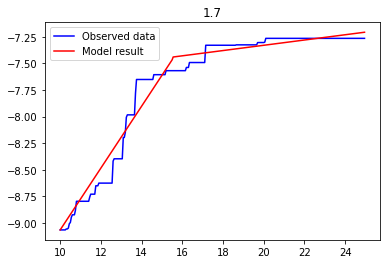

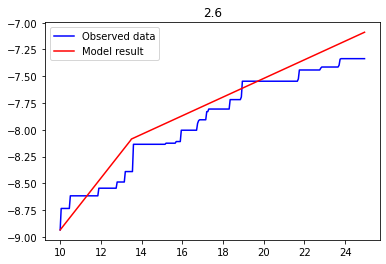

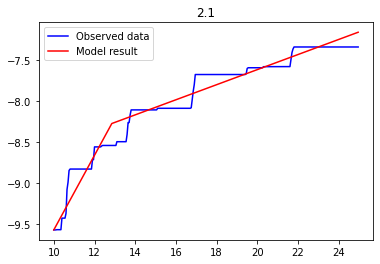

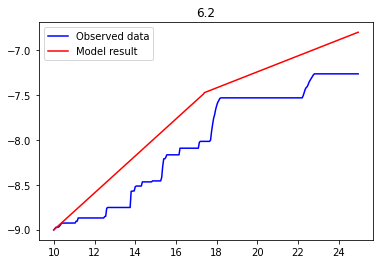

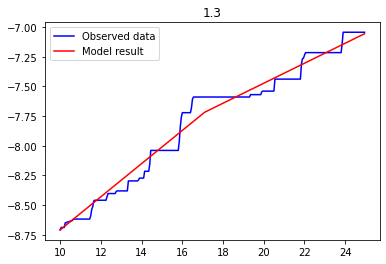

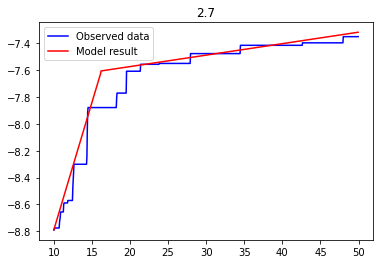

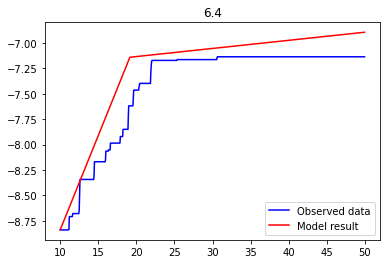

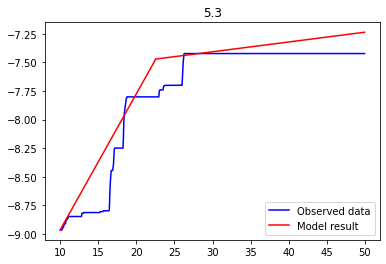

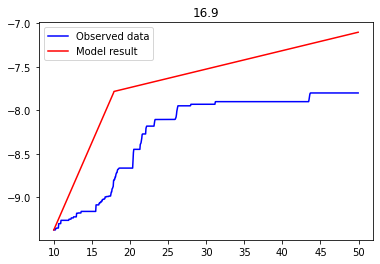

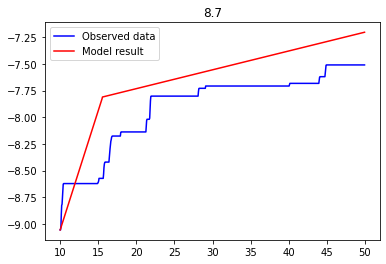

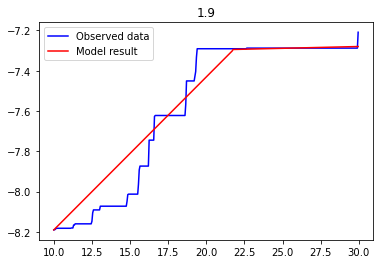

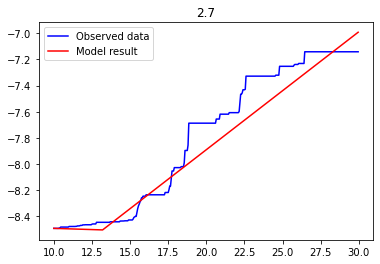

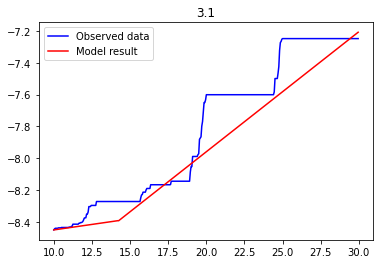

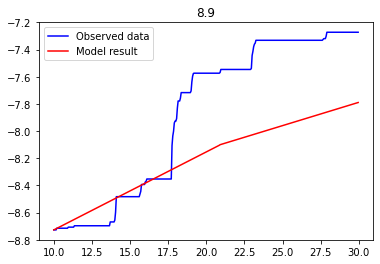

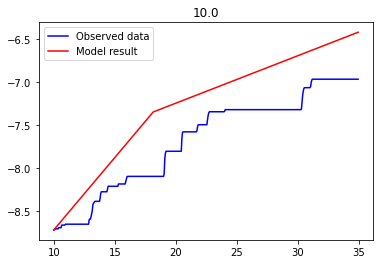

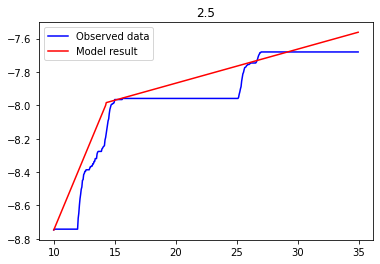

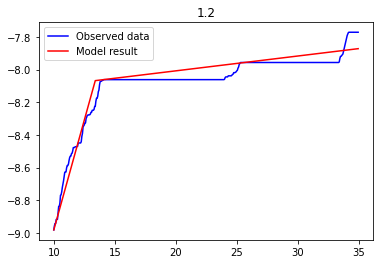

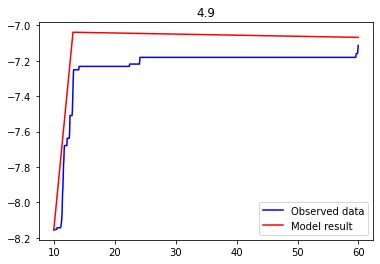

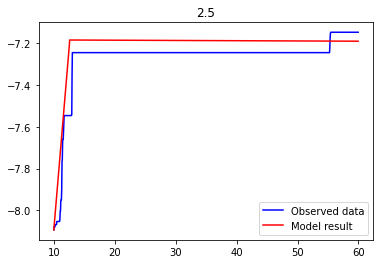

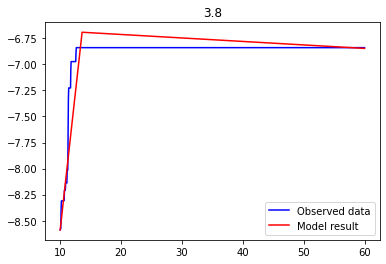

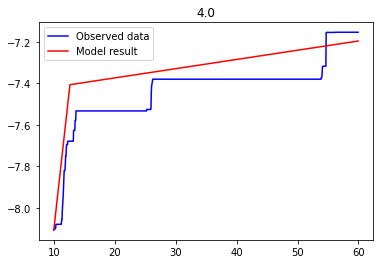

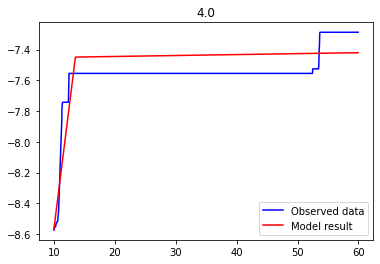

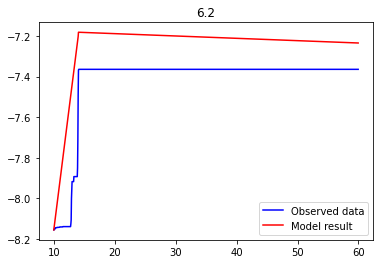

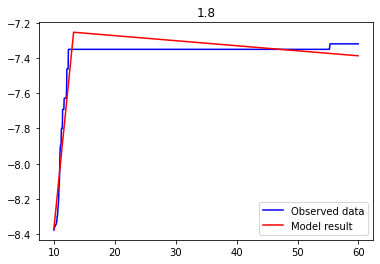

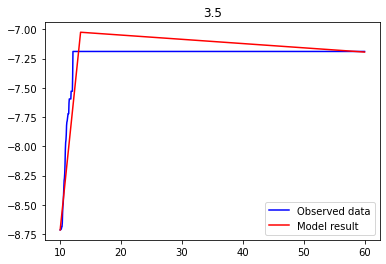

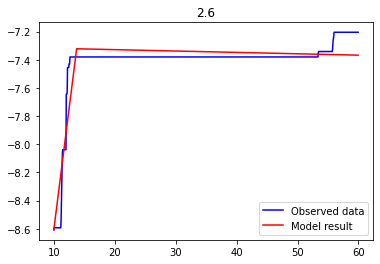

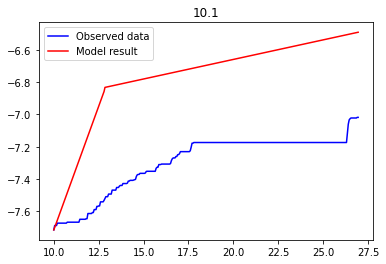

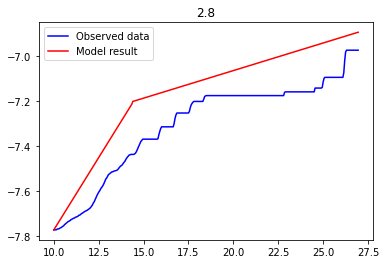

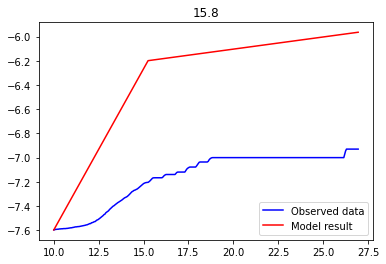

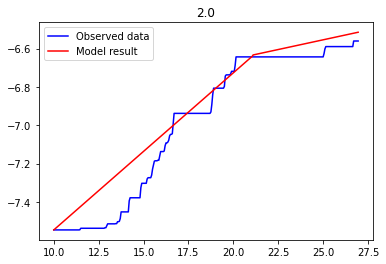

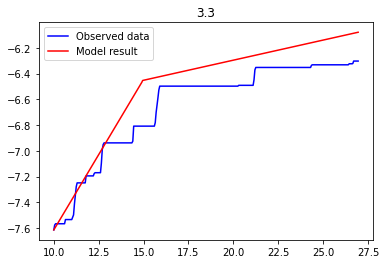

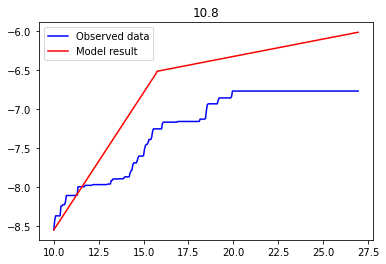

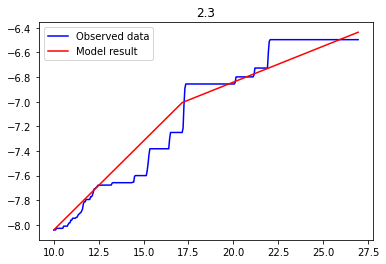

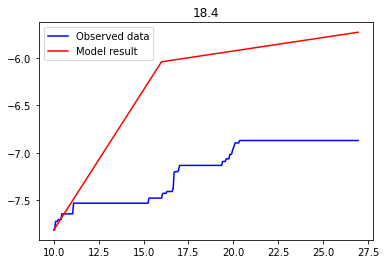

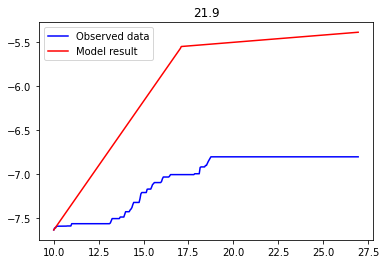

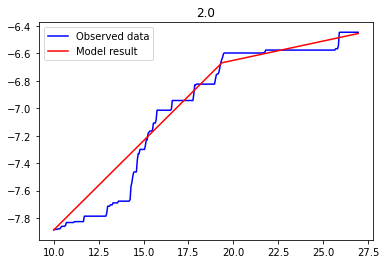

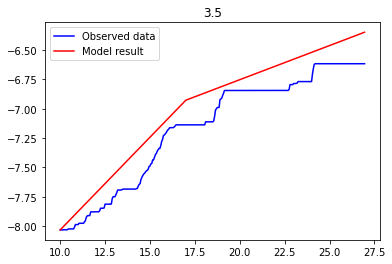

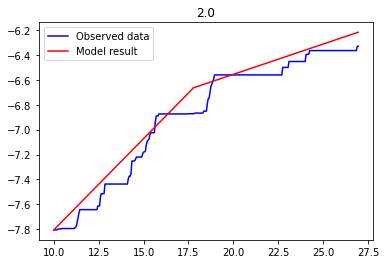

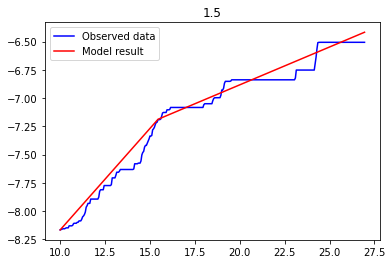

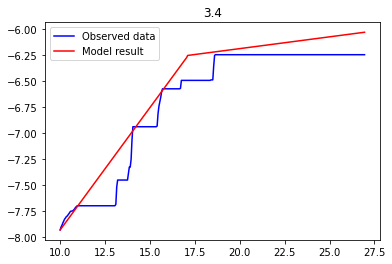

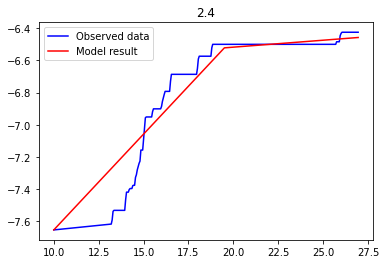

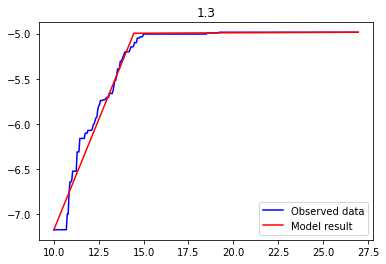

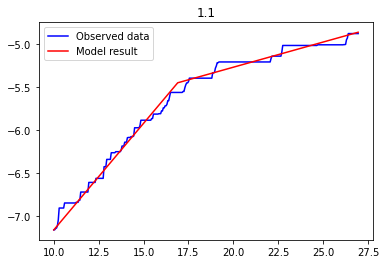

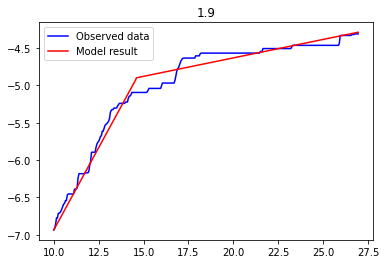

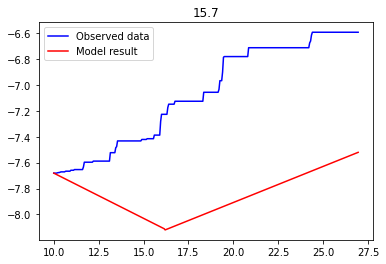

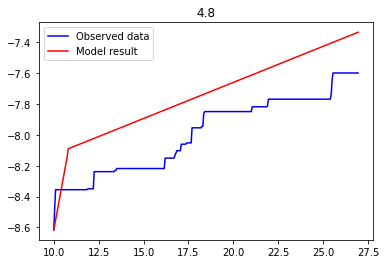

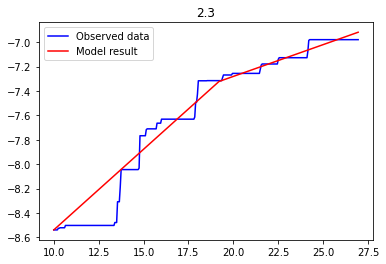

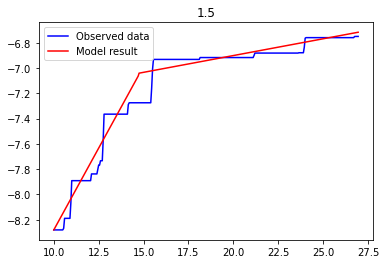

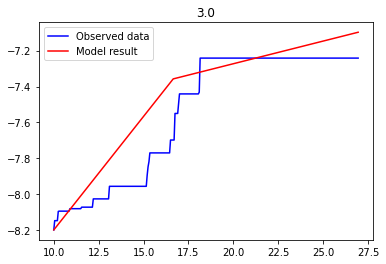

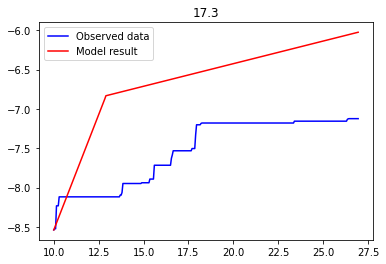

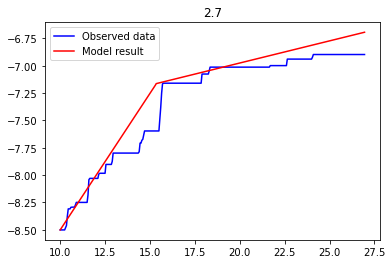

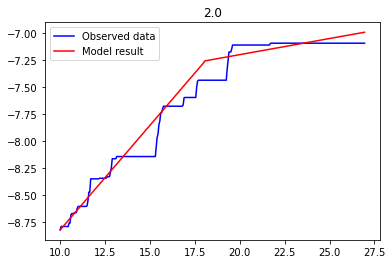

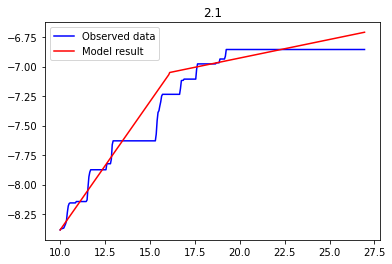

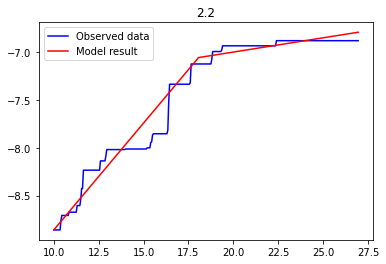

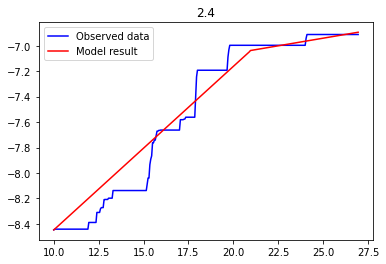

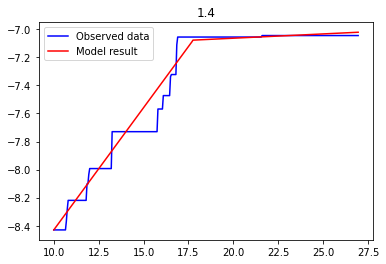

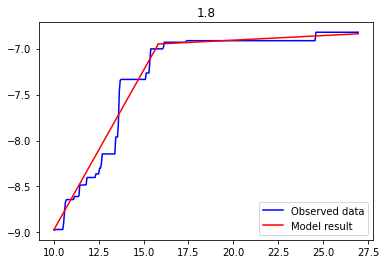

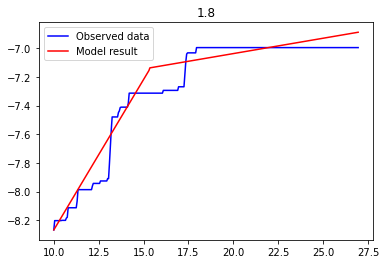

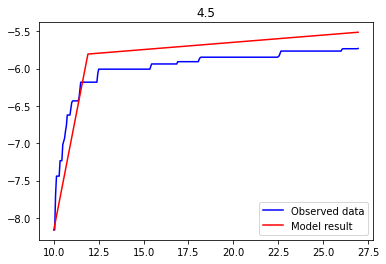

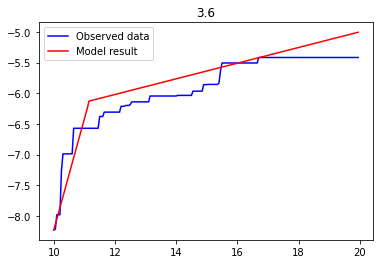

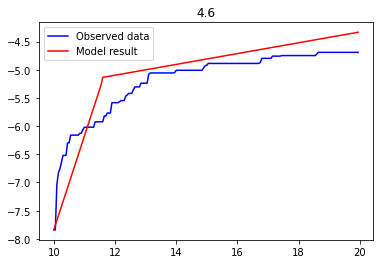

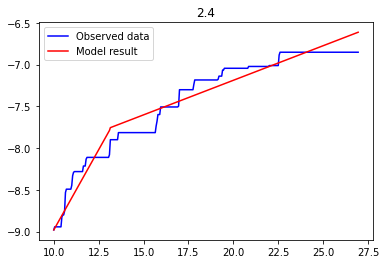

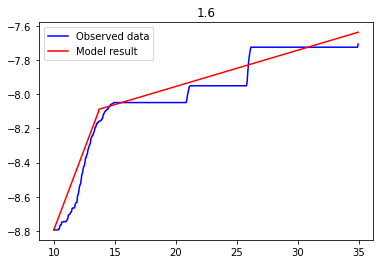

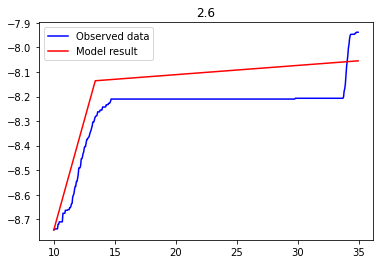

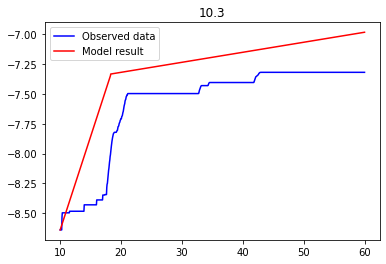

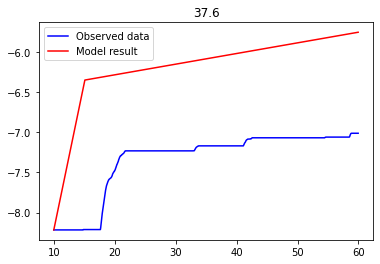

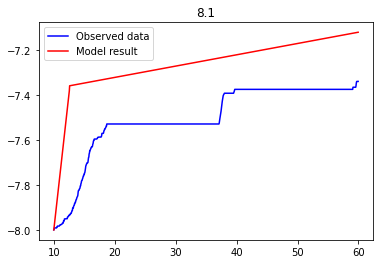

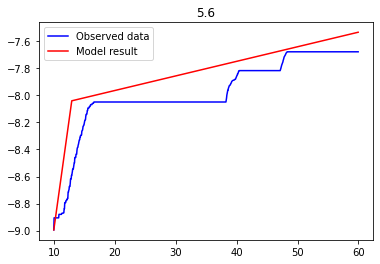

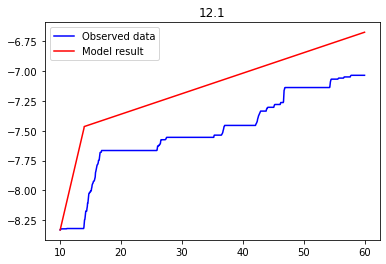

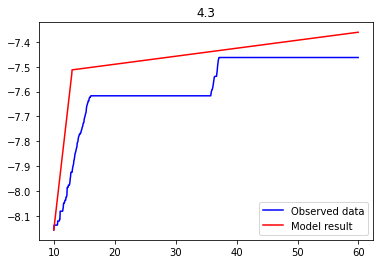

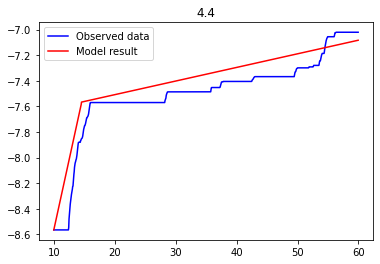

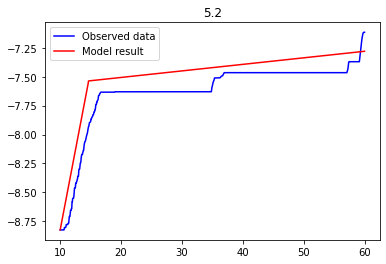

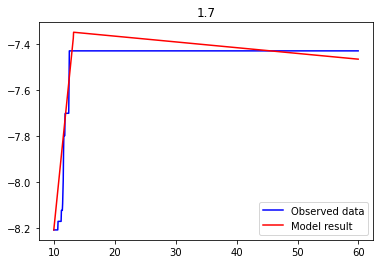

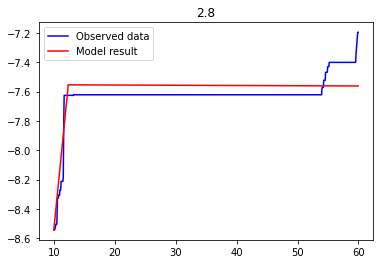

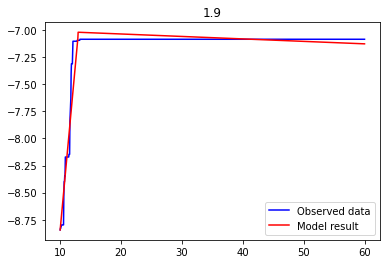

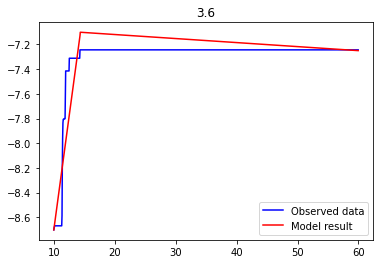

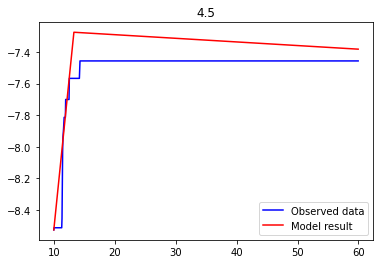

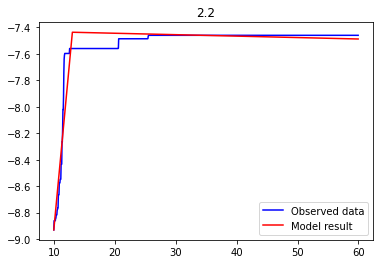

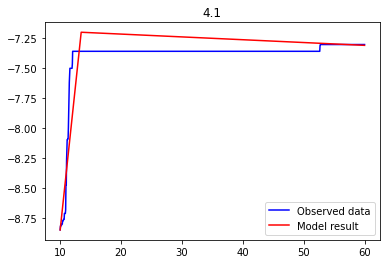

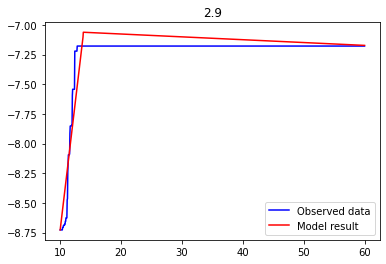

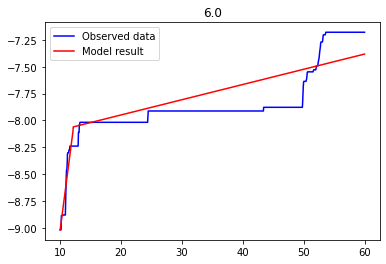

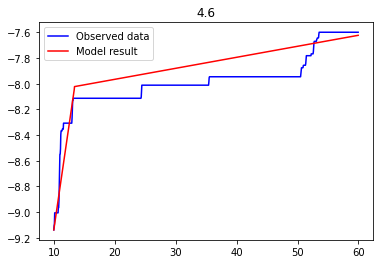

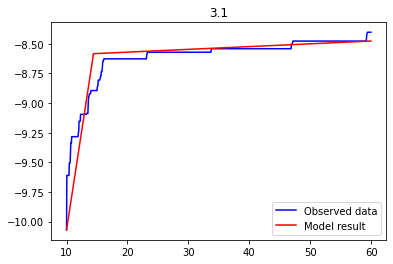

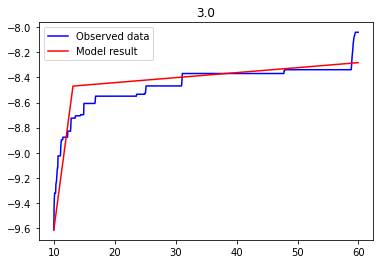

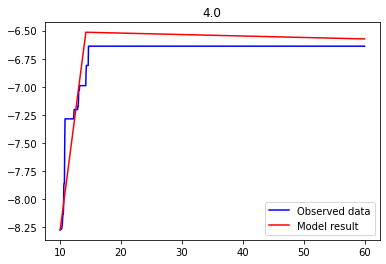

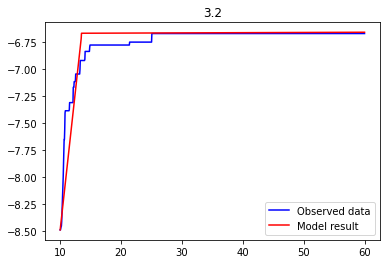

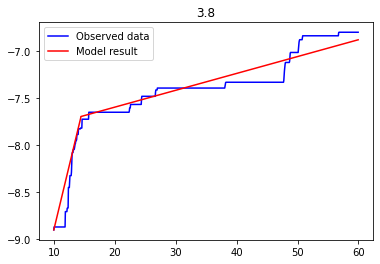

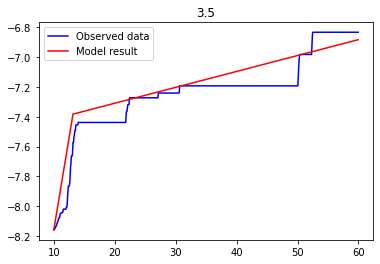

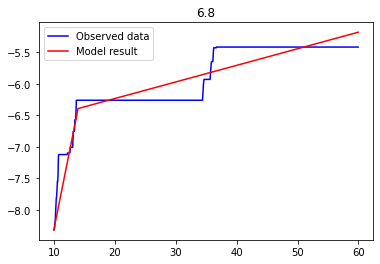

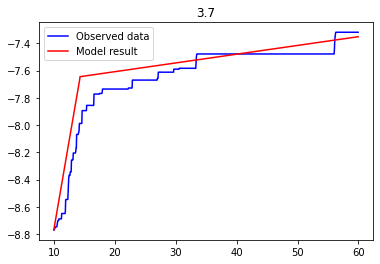

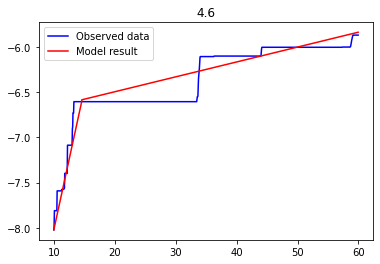

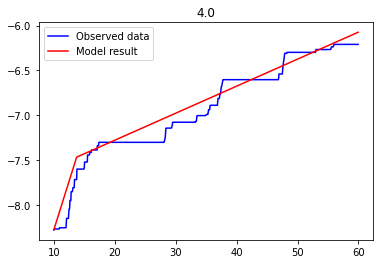

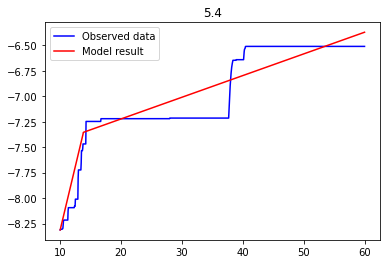

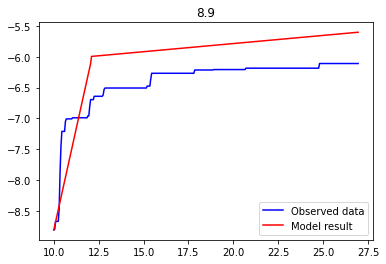

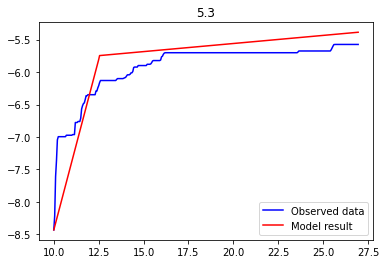

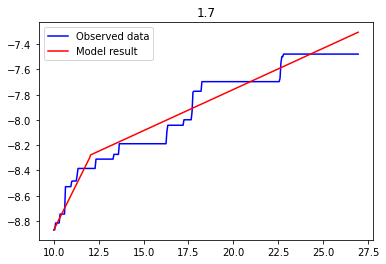

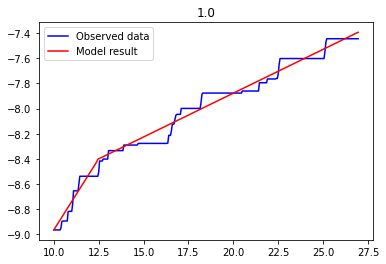

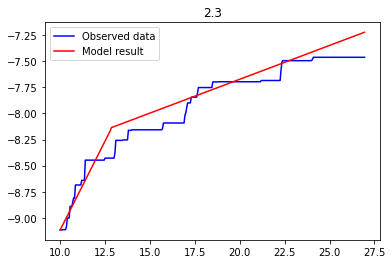

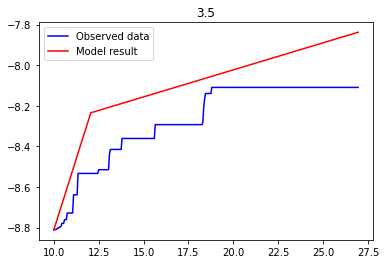

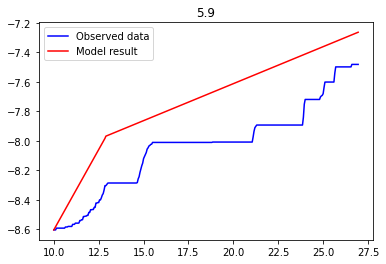

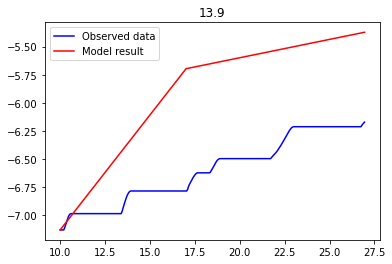

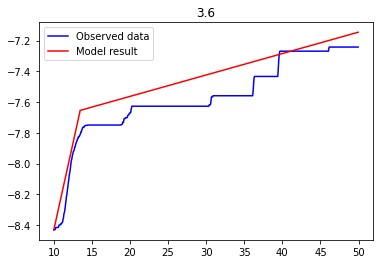

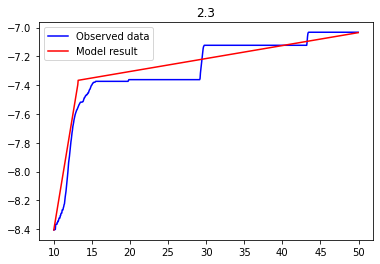

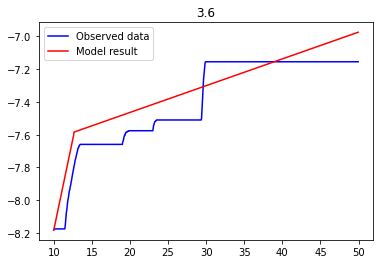

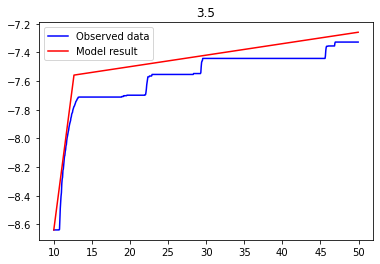

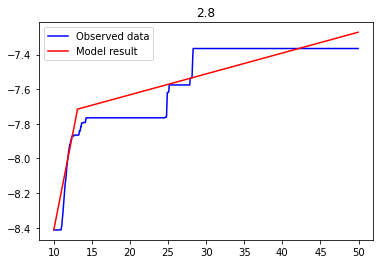

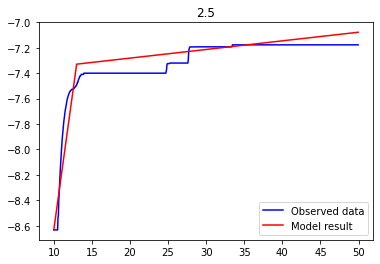

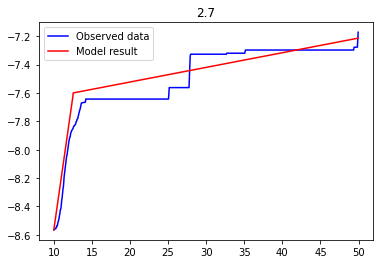

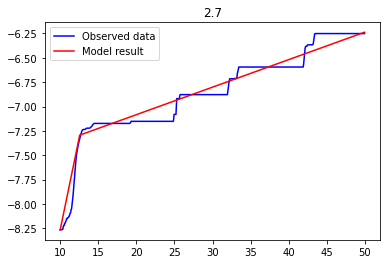

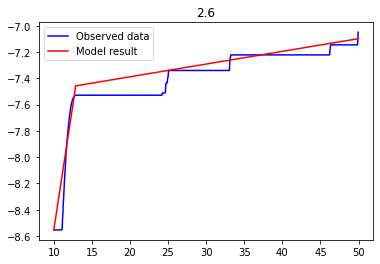

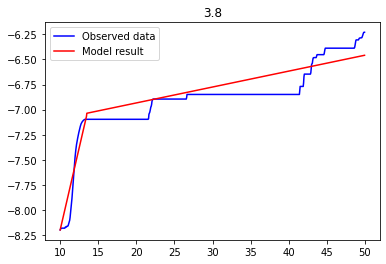

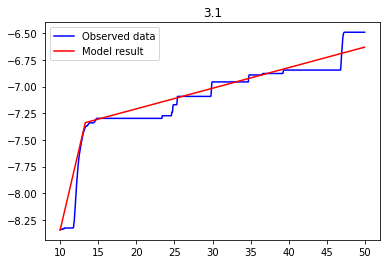

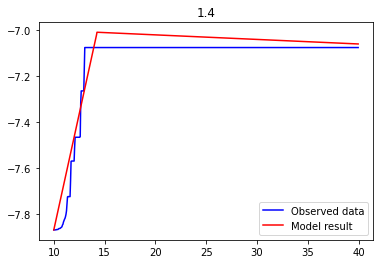

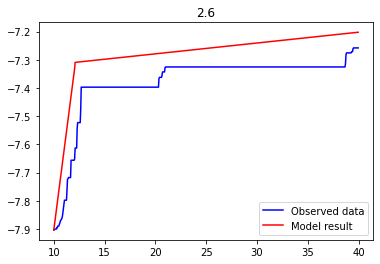

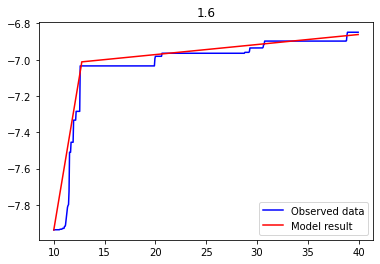

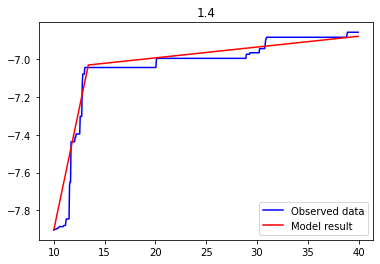

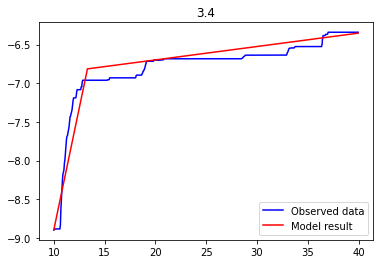

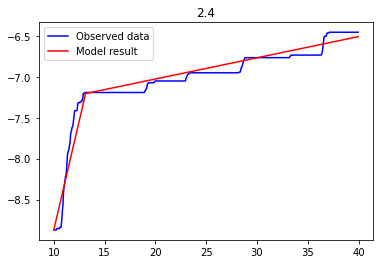

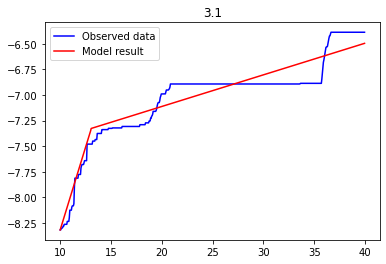

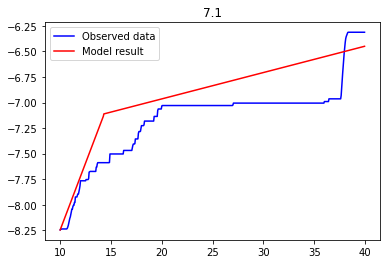

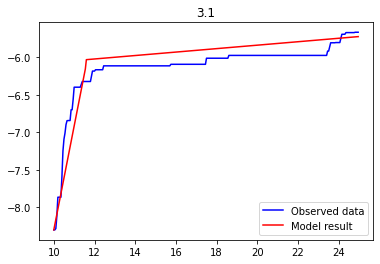

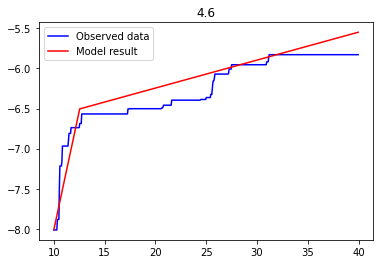

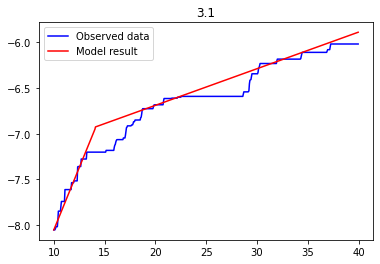

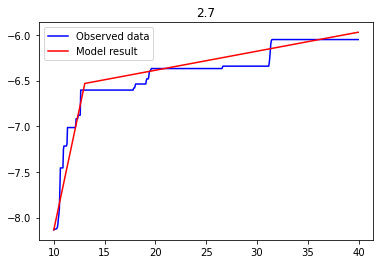

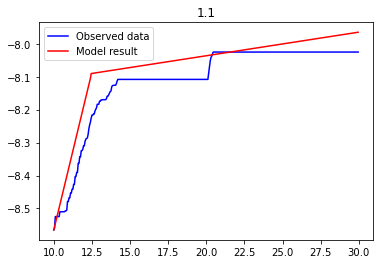

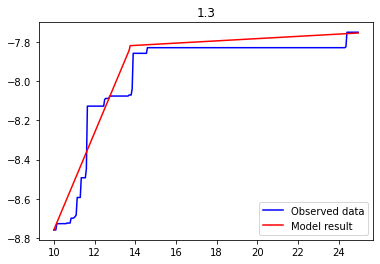

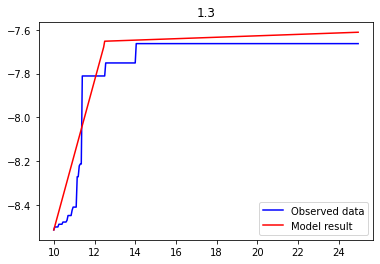

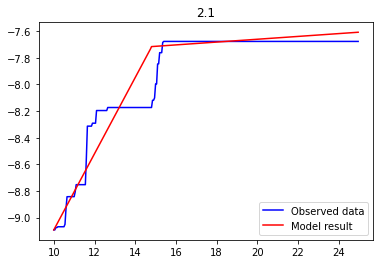

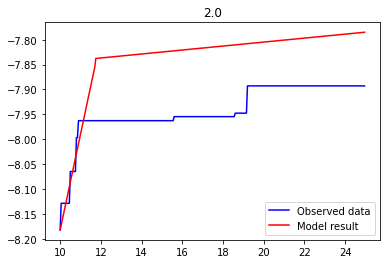

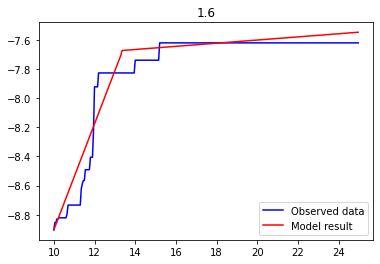

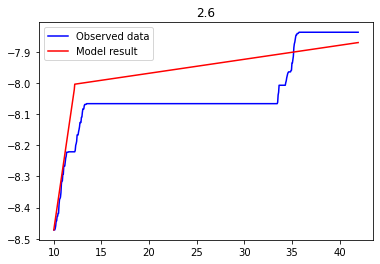

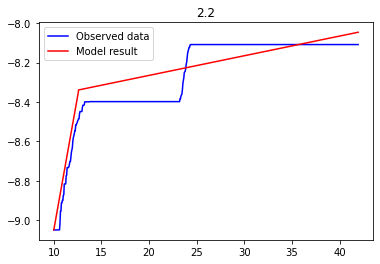

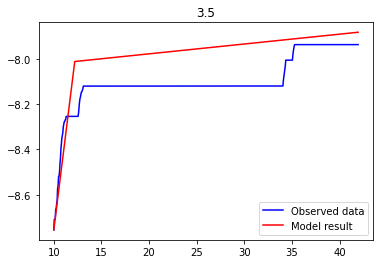

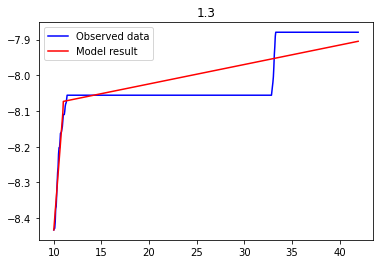

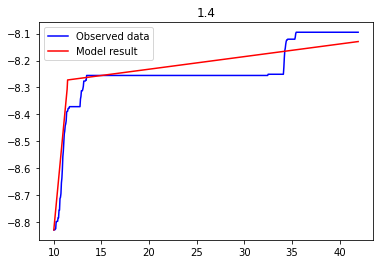

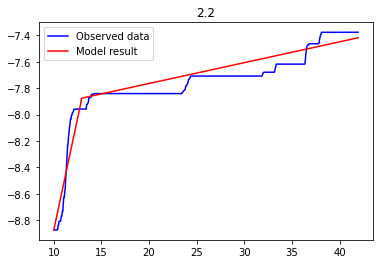

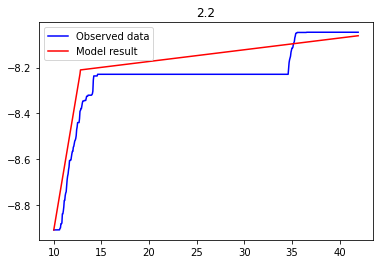

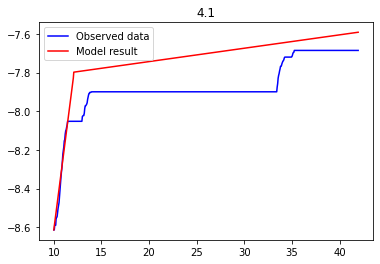

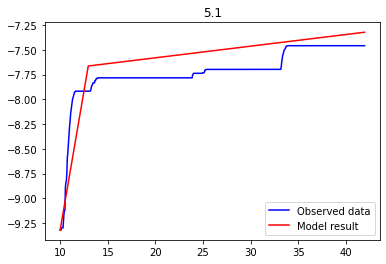

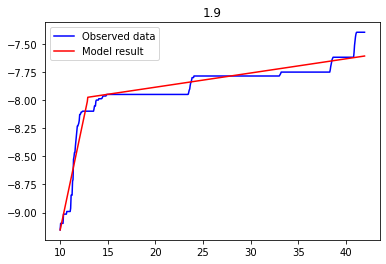

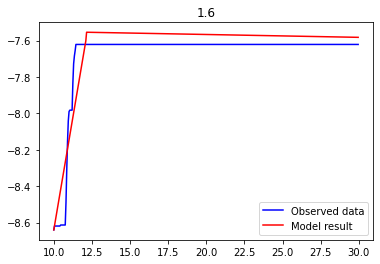

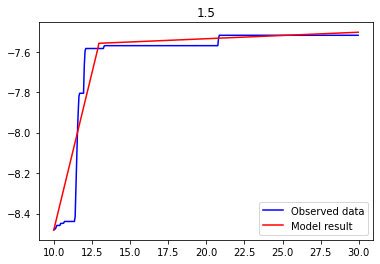

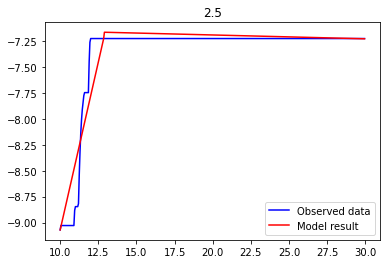

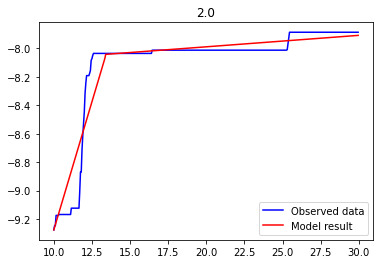

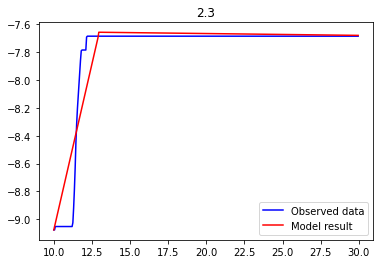

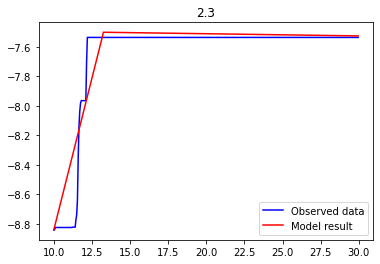

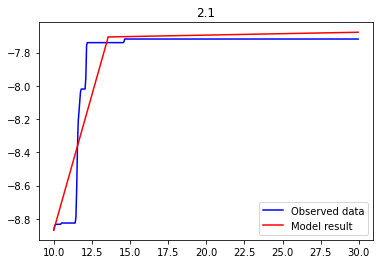

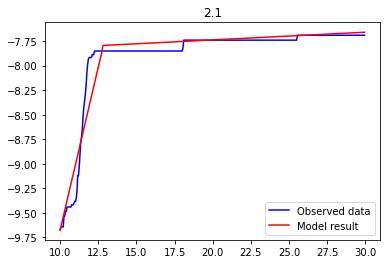

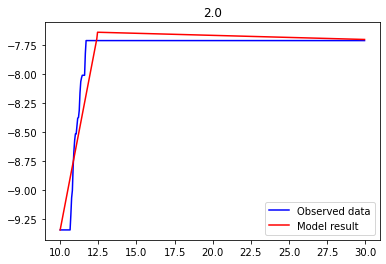

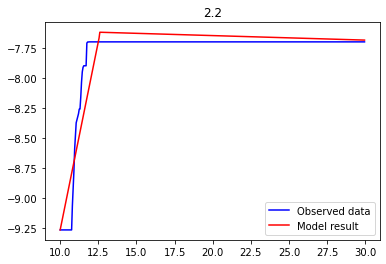

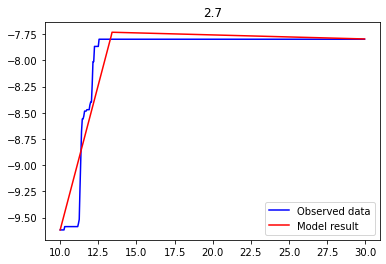

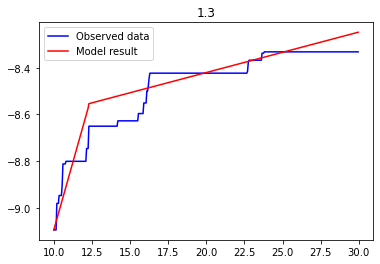

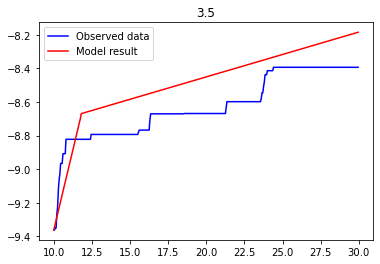

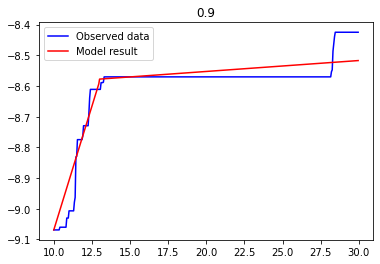

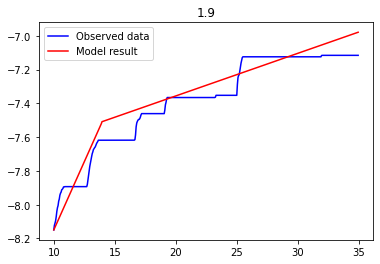

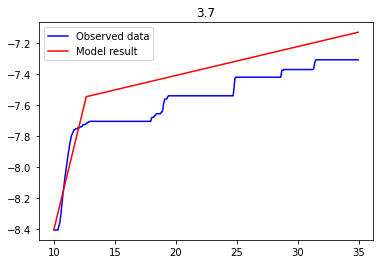

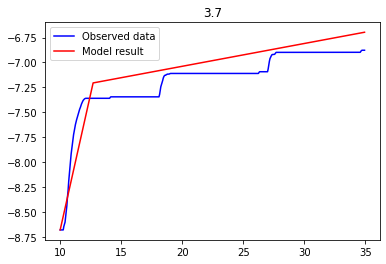

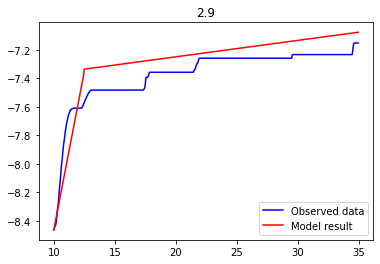

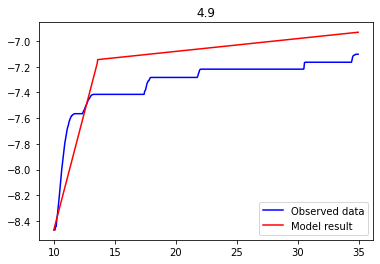

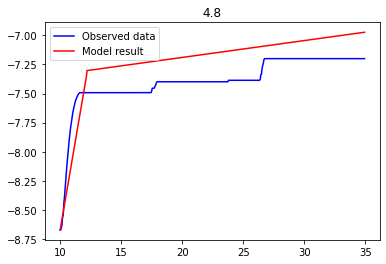

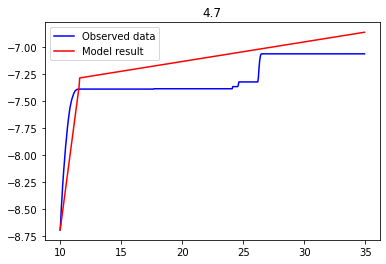

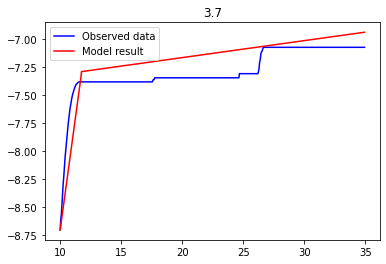

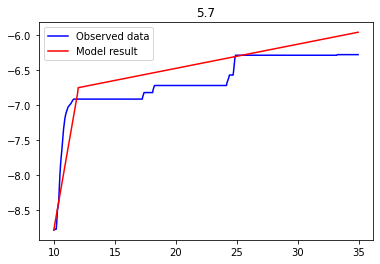

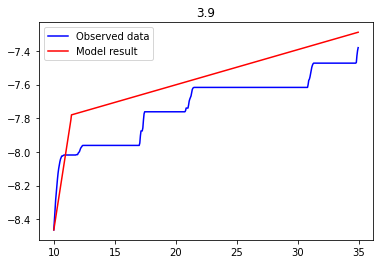

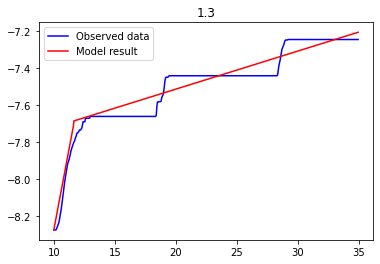

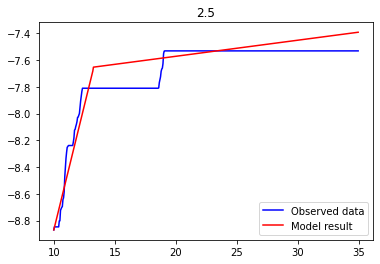

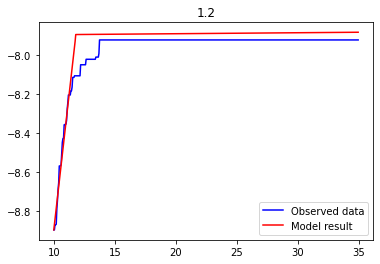

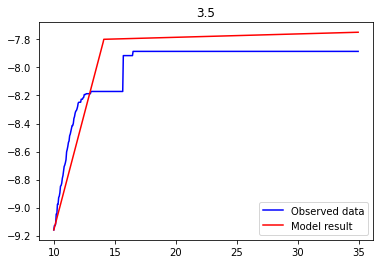

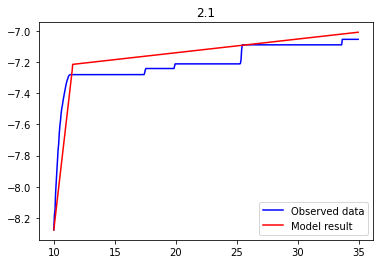

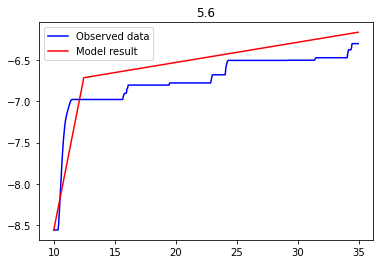

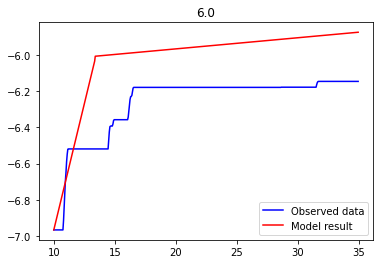

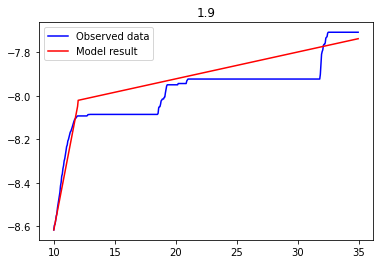

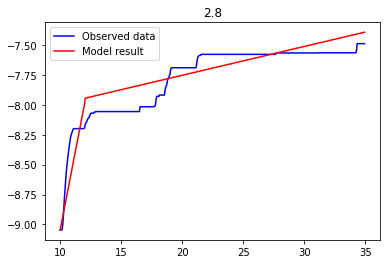

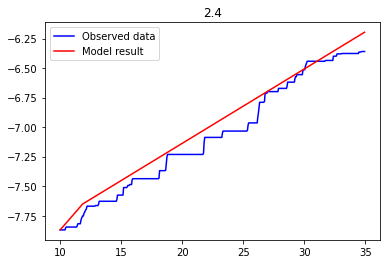

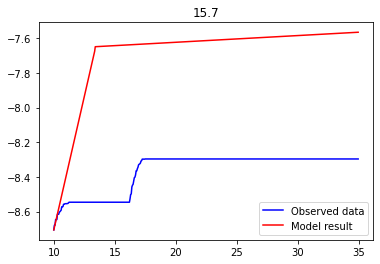

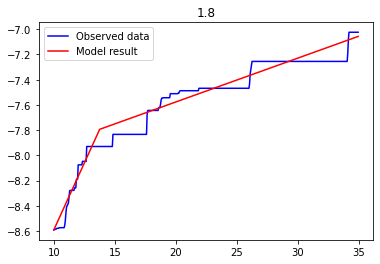

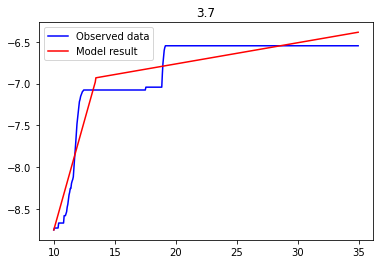

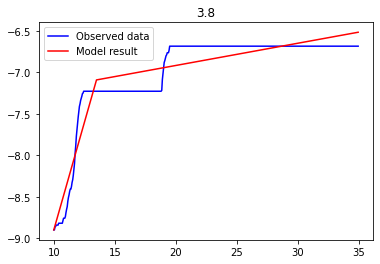

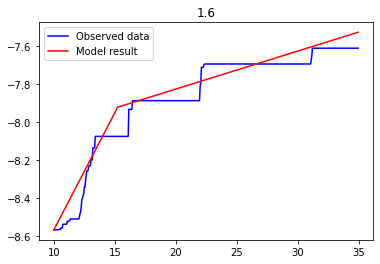

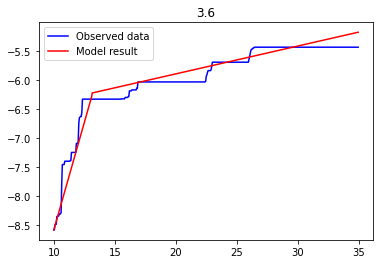

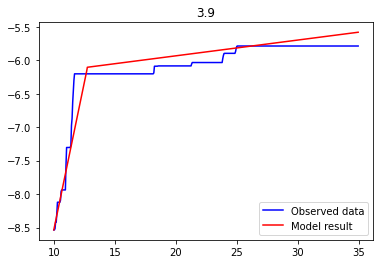

In [90]:
counter = 0

for idx in range(len(mcmc_results_array)):
    
    eq_id = str(mcmc_results_array[idx,0])
    sta = str(mcmc_results_array[idx,2])
    hypdist = int(mcmc_results_array[idx,3])

    # print(eq_id, sta, hypdist)

    # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
    xlow = 10
    xhigh = get_xhigh(eq_id)
    
    try:
        # Read in data - peak strain data only has the ones with SNR > 2
        pst = read(path_to_files + 'strain_data/filtered_peak_post_p/' + eq_id + '/' + sta + '.mseed')
        counter += 1
        # pst.plot()
        # plt.plot(pst[0].times(), pst[0].data)
        # plt.semilogy()
        # plt.show()

    except:
        continue # Skips to next row in dist_array/next station

    times = pst[0].times()
    data = pst[0].data
    log10_data = np.log10(data)
    samp_rate = pst[0].stats.sampling_rate
    
    vec_start = int(xlow*samp_rate)
    vec_end = int(xhigh*samp_rate)

    xobserved = times[vec_start:vec_end]
    yobserved = log10_data[vec_start:vec_end]
    x0 = xobserved[0]
    y0 = yobserved[0]
    
    m1_slope = float(mcmc_results_array[idx,5])
    m2_slope = float(mcmc_results_array[idx,6])
    int_time = float(mcmc_results_array[idx,7])
    
    int_x_samp = int(int_time*samp_rate)
    
    # mx + b for the lines
    
    b1 = y0 - m1_slope*x0
    b2 = m1_slope*int_time + b1 - m2_slope*int_time
    
    line1_xobs = times[vec_start:int_x_samp]
    line1_ymodel = m1_slope * line1_xobs + b1
    line1_yobs = log10_data[vec_start:int_x_samp]
    
    line2_xobs = times[int_x_samp:vec_end]
    line2_ymodel = m2_slope * line2_xobs + b2
    line2_yobs = log10_data[int_x_samp:vec_end]
    
    xobs = np.append(line1_xobs, line2_xobs)
    ymodel = np.append(line1_ymodel, line2_ymodel)
    yobs = np.append(line1_yobs, line2_yobs)
    
    error = np.sqrt(np.sum(np.square(np.subtract(ymodel, yobs))))
    # print(error)
    
    plt.title(round(error,1))
    plt.plot(xobs, yobs, color = 'blue', label = 'Observed data')
    plt.plot(xobs, ymodel, color = 'red', label = 'Model result')
    plt.legend()
    plt.show()
        

In [76]:
counter

200

In [ ]:
def get_xhigh(eq_id):
    
    if eq_id == '2023-04-13_M6':
        xhigh = 60
    elif eq_id == '2022-12-20_M6.4':
        if hypdist < 200:
            xhigh = 20
        else:
            xhigh = 40
    elif eq_id == '2022-11-22_M6.2': # Weird one that pauses for a while then grows again
        xhigh = 25
    elif eq_id == '2021-12-20_M6.2':
        if hypdist < 30: 
            xhigh = 20
        elif 30 < hypdist < 50:
            xhigh = 25
        elif 50 < hypdist < 100:
            xhigh = 30
        else:
            xhigh = 60
    elif eq_id == '2021-07-08_M6': # Lots of more gradual ones with pause again
        if hypdist < 300:
            xhigh = 25
        else:
            xhigh = 50
    elif eq_id == '2020-05-15_M6.5':
        xhigh = 30
    elif eq_id == '2020-03-31_M6.5':
        xhigh = 35
    elif eq_id == '2019-12-25_M6.3':
        xhigh = 35
    elif eq_id == '2019-12-23T20_M6':
        xhigh = 60
    elif eq_id == '2019-12-23T19_M6':
        xhigh = 60
    elif eq_id == '2019-08-29_M6.3': # All flatten fast
        xhigh = 60
    elif eq_id == '2019-07-06_M7.1': # Ridgecrest mainshock
        xhigh = 27
    elif eq_id == '2019-07-04_M6.4': # Ridgecrest foreshock
        if hypdist < 50:
            xhigh = 20
        else:
            xhigh = 27
    elif eq_id == '2019-07-04_M6.2':
        xhigh = 35
    # elif eq_id == '2018-10-22T06_M6.5': # No waveforms with high enough SNR
    #     xhigh = 
    elif eq_id == '2018-10-22_M6.8': # Has like 3 slopes? Letting it go long
        xhigh = 60
    elif eq_id == '2018-10-22T05_M6.5': # Somewhat of a pause but all similar? Going long
        xhigh = 60
    elif eq_id == '2018-08-22_M6.2':
        xhigh = 60
    elif eq_id == '2016-12-08_M6.6':
        xhigh = 60
    elif eq_id == '2014-08-24_M6.02':
        xhigh = 27
    elif eq_id == '2014-04-24_M6.5':
        xhigh = 50
    elif eq_id == '2014-03-10_M6.8':
        if hypdist < 110:
            xhigh = 25
        else:
            xhigh = 40
    elif eq_id == '2013-09-04_M6':
        xhigh = 25
    elif eq_id == '2013-09-03_M6.1':
        xhigh = 30
    elif eq_id == '2012-12-14_M6.3':
        xhigh = 25
    elif eq_id == '2012-11-08_M6.1':
        xhigh = 42
    elif eq_id == '2012-04-11_M6':
        xhigh = 30
    elif eq_id == '2011-09-09_M6.4':
        xhigh = 35
    elif eq_id == '2010-04-04_M7.2':
        xhigh = 35
    elif eq_id == '2010-01-10_M6.5':
        xhigh = 35
    elif eq_id == '2008-01-10_M6.3':
        xhigh = 24
    else:
        xhigh = 'no data'
    
    return xhigh